In [1]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append('../')
from sklearn.metrics import mean_squared_error
import re
import numpy as np

In [2]:
from core.models import rUNet
from core.utils.inference import inference_phase_rUNet_plot_notebook
from core.utils.data import define_dataset, select_dist

In [3]:
from core.utils.data.transformers import ChannelsFirst, Rescale, ToTensor, Crop, GaussianNoise, RandomCrop, Swap, \
        FlipUD, FlipLR

In [4]:
from functools import partial

In [5]:
import torch

In [6]:
%matplotlib inline

In [7]:
regex = re.compile(r'\d+')

In [8]:
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_fromscratch_6positions_multi_loss_augmentation_noise150/'

In [9]:
root_path = partial(os.path.join, saved_models)

In [10]:
data_folder = ('/storage/yw18581/data/dataset/')

In [11]:
model_names = os.listdir(saved_models)

In [12]:
def get_fnames(coeff, prefix='Trained'):
    idx_coef = 6 if prefix=='Trained' else 4
    idx_epoch = 5 if prefix =='Trained' else 3
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith(prefix):
            if regex.findall(fname.split("_")[idx_coef])[1]==str(coeff):
                epoch = int(regex.findall(fname.split("_")[idx_epoch])[0]) 
                epochs.append(epoch)
                if int(regex.findall(fname.split("_")[idx_epoch])[0])==epoch:
                    f_list.append(fname)
    
    return np.array(f_list)[np.argsort(epochs)], np.sort(epochs)

---

### Inference on test unseen data

In [13]:
training_dist = [2,4,10,20,25,35]
unseen_dist = [1,3,15,30]
selected_distances = select_dist(data_folder, unseen_dist)

In [14]:
base_transformers = [Crop(row_slice=slice(0,1400), col_slice=slice(1000,None)),
                           Rescale(scale=0.25), ChannelsFirst(),ToTensor()]

In [15]:
base_transfofrmers_2 = [RandomCrop(p=1), Swap(p=0.7), FlipLR(p=0.7), FlipUD(p=0.7),
                        Rescale(0.25), ChannelsFirst(),ToTensor()]

In [16]:
data_loaders, data_length = define_dataset(root_folder=data_folder, 
                                           base_transformers=base_transformers,
                                           train_transformers=base_transformers,
                                           batch_size=2, include_list=selected_distances,
                                            alldata=True, multi_processing=4)

In [17]:
def predict_coef_epoch(coeff, epoch):
    filelist, epochs = get_fnames(coeff)
    model_fname = filelist[int(np.argwhere(epochs==epoch)[0])]
    print(model_fname)
    torch.cuda.empty_cache()
    model = rUNet(out_size=1)
    checkpoint = torch.load(root_path(model_fname))['model_state_dict']
    #print(checkpoint)
    model.load_state_dict(checkpoint)
    
    print('Checkpoint loaded')
    inference_phase_rUNet_plot_notebook(model, data_loaders, data_length,
                                       batch_size=4, stop=1, test=False)

    return

Trained_rUNet_pytorch_6positions_dataset_50epochs_0.4coeff_mask.pkl
Checkpoint loaded


batch 1
1: true_dist: 15, pred_dist: [15.653815]


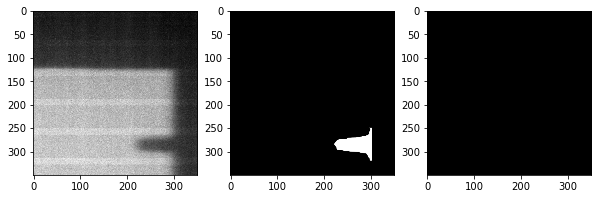

2: true_dist: 15, pred_dist: [16.655697]


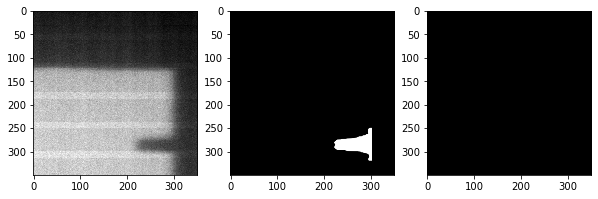

batch 2
1: true_dist: 15, pred_dist: [16.307817]


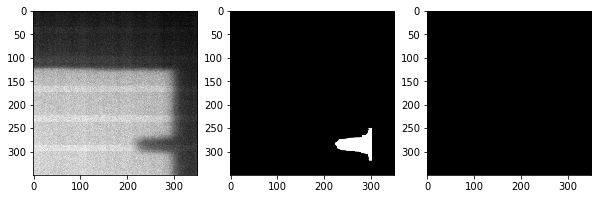

2: true_dist: 15, pred_dist: [15.5153265]


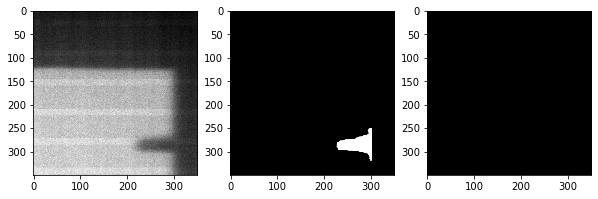

Trained_rUNet_pytorch_6positions_dataset_60epochs_0.4coeff_mask.pkl

Checkpoint loaded


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f05c7fc70d0>
Traceback (most recent call last):
  File "/storage/yw18581/src/env_dir/mlearning/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/storage/yw18581/src/env_dir/mlearning/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/storage/yw18581/src/env_dir/mlearning/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/storage/yw18581/src/env_dir/mlearning/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/storage/yw18581/src/env_dir/mlearning/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


batch 1
1: true_dist: 15, pred_dist: [14.956483]


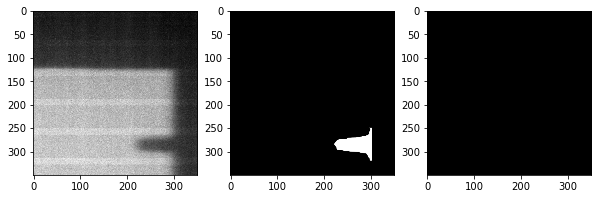

2: true_dist: 15, pred_dist: [15.472094]


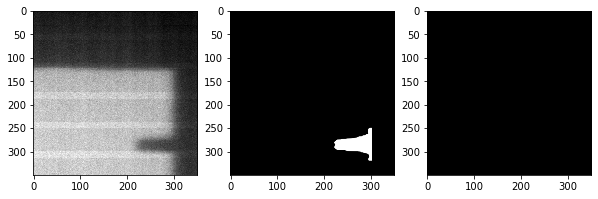

batch 2
1: true_dist: 15, pred_dist: [15.124539]


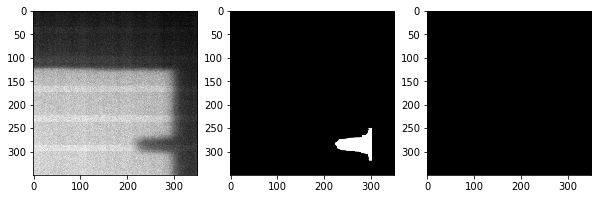

2: true_dist: 15, pred_dist: [14.197585]


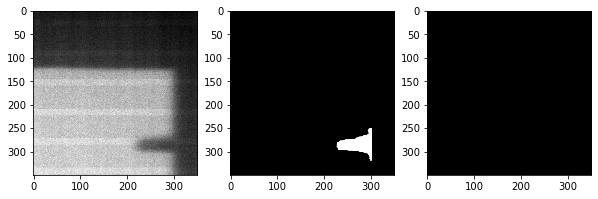

Trained_rUNet_pytorch_6positions_dataset_70epochs_0.4coeff_mask.pkl
Checkpoint loaded


batch 1
1: true_dist: 15, pred_dist: [15.859968]


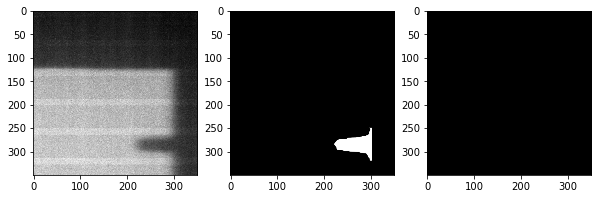

2: true_dist: 15, pred_dist: [16.522882]



In [ ]:
for epoch in np.arange(50, 110, 10):
    predict_coef_epoch(4, epoch)

Trained_rUNet_pytorch_6positions_dataset_100epochs_0.4coeff_mask.pkl
Checkpoint loaded


batch 1
1: true_dist: 15, pred_dist: [15.457664]


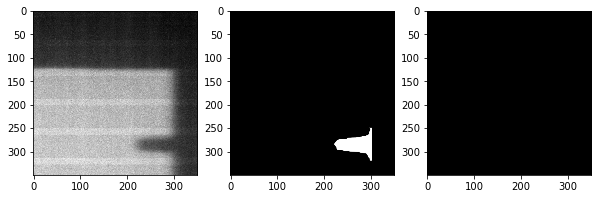

2: true_dist: 15, pred_dist: [16.03846]


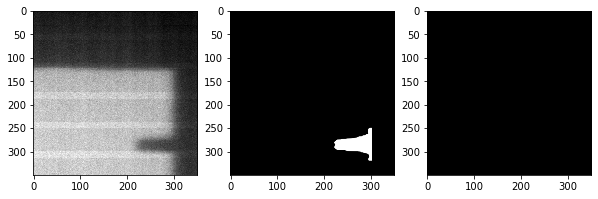

batch 2
1: true_dist: 15, pred_dist: [15.822365]


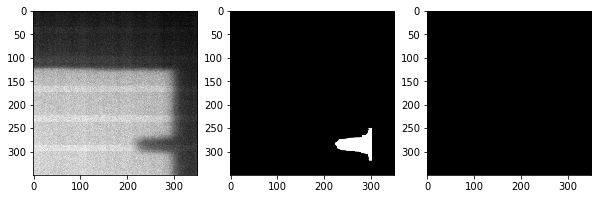

2: true_dist: 15, pred_dist: [15.330501]


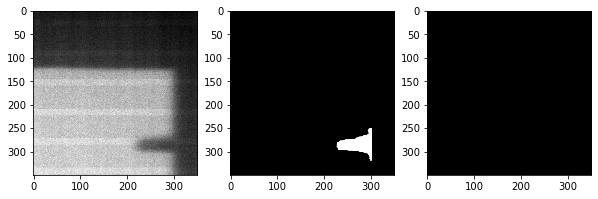

In [18]:
predict_coef_epoch(4, 100)

### Test on multi-leaf dataset

In [19]:
data_folder_multi = '/storage/yw18581/data/v2_avg/top_right/'

In [20]:
excluded = []

In [21]:
data_loaders, data_length = define_dataset(root_folder=data_folder_multi, base_transformers=base_transformers,
                                           train_transformers=base_transformers,
                                           batch_size=4, excluded_list=excluded,
                                            alldata=True, multi_processing=4, load_mask=False)

In [22]:
def inference_phase_rUNet_plot_notebook(model, data_loaders, data_lengths, batch_size, stop=1, dev=0, test=True):
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt

    device = torch.device("cuda:{}".format(dev) if torch.cuda.is_available() else "cpu")
    # model = cUNet(out_size=1)

    # model.load_state_dict(torch.load(model_name))
    model.eval()
    model.to(device);
    for i, batch in tqdm(enumerate(data_loaders), total=data_lengths // batch_size,
                     desc="Batch"):

        true_images = batch["image"]
        pred_masks, pred_dists = model(true_images.float().to(device))
        print("batch {}".format(i + 1))
        for j, (img, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                                        pred_masks.cpu().detach().numpy(),
                                                                        pred_dists.cpu().detach().numpy())):
            print("{}: pred_dist: {}".format(j + 1, pr_dist))

            f = plt.figure(figsize=(10, 5))
            f.add_subplot(1, 2, 1)
            plt.imshow(img[0, ...], cmap='gray')
            f.add_subplot(1, 2, 2)
            plt.imshow(pr_msk[0, ...], cmap='gray')
            plt.show(block=True)

        if i == stop:
            break

Trained_rUNet_pytorch_6positions_dataset_100epochs_0.4coeff_mask.pkl
Checkpoint loaded


batch 1
1: pred_dist: [-7.5759535]


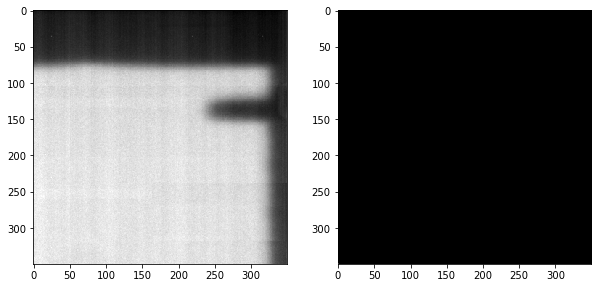

2: pred_dist: [-7.5556207]


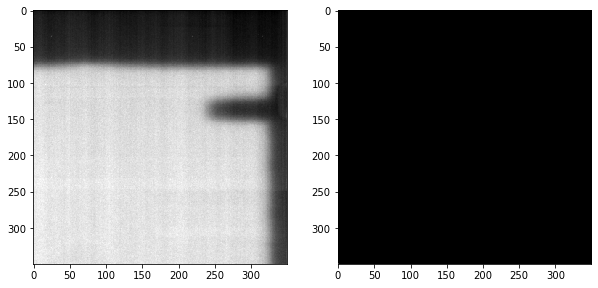

3: pred_dist: [-7.5372305]


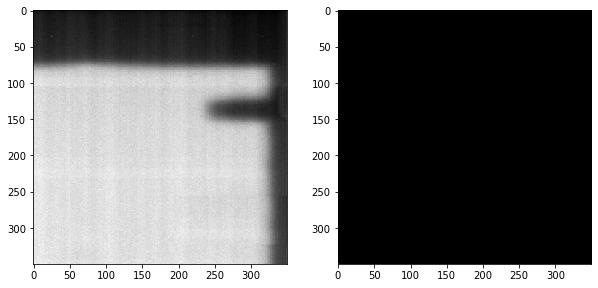

4: pred_dist: [-7.5110803]


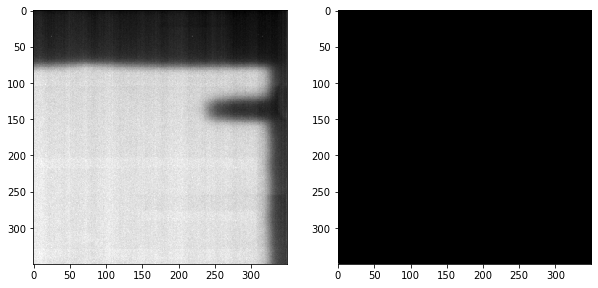

batch 2
1: pred_dist: [-7.500457]


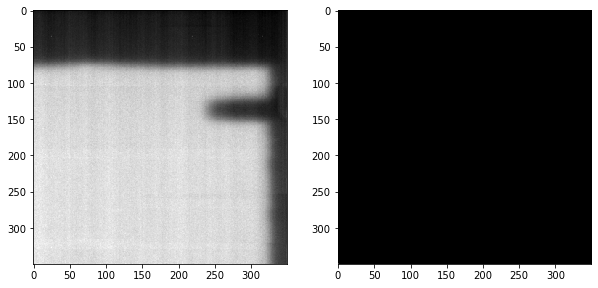

2: pred_dist: [-7.5201607]


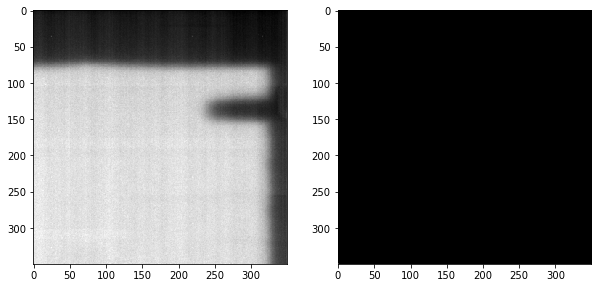

3: pred_dist: [-7.5012593]


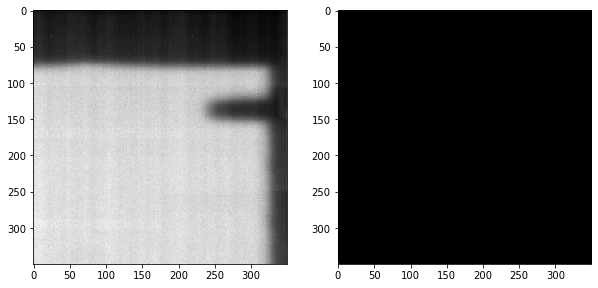

4: pred_dist: [-7.516242]


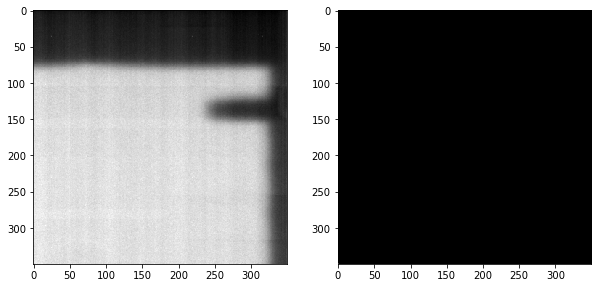

In [23]:
predict_coef_epoch(4,100)

---

#### Check training performance

In [32]:
history = np.load(os.path.join(saved_models,model_names[-1]), allow_pickle=True)

In [39]:
history.keys()

dict_keys(['train', 'val', 'train_dice', 'train_mse', 'val_dice', 'val_mse', 'epochs'])

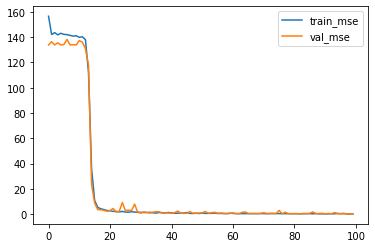

In [46]:
for key in history.keys():
    if 'mse'in key:
        plt.plot(history['epochs'], history[key], label=key)
plt.legend(loc='upper right')

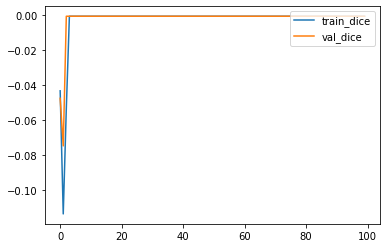

In [47]:
for key in history.keys():
    if 'dice'in key:
        plt.plot(history['epochs'], history[key], label=key)
plt.legend(loc='upper right')